In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from synchrad.calc import SynchRad
from synchrad.utils import r_e, omega_1m, alpha_fs

from scipy.constants import e, m_e, c, epsilon_0, hbar
from scipy.integrate import solve_ivp

# Example of the undulator radiation

## Defining undulator and particle parameters

In [2]:
Np = 10           # Number of electrons
Num_osc = 50      # Number of oscillations

# Undulator
lambda_u = 15e-3
K0 = 0.1
phase = -np.pi/2

# particles/beam central energy
particle_energy_MeV = 100

# Technical parameters
gamma_0 = particle_energy_MeV * 1e6 * e / (m_e * c**2)
pz0 = (gamma_0**2 - 1 - K0**2)**.5

k_u = 2 * np.pi / lambda_u
omega_u = k_u * c
omega_u_rad = 2 * gamma_0**2 * omega_u / (1 + K0**2 / 2)
lambda_u_rad = omega_1m/omega_u_rad

L_u = Num_osc * lambda_u
T_fin  = L_u / c

# Resolving track with 64 steps per oscillation
Nt = L_u/lambda_u * 64
t_eval = np.r_[0: T_fin: 1j * Nt]
dt = t_eval[1] - t_eval[0]

# Track initial values
trak0 = np.zeros((6, Np))
# Make a train of particles spaced by lambda_u_rad
xlim = (-(Np / 2) * lambda_u_rad, (Np / 2 - 1) * lambda_u_rad)
trak0[2, :] = np.r_[xlim[0]: xlim[1]: 1j * Np]
# Set energy spread
trak0[5, :] = pz0 * (1 + 1e-3 * np.random.standard_normal(Np))

## Solving equations of particle motion in the ideal undulator field

### Define function to calculate the particle trajectories

In [3]:
def motion_undulator(t, track, K0, k_u, phase):
    x, y, z, ux, uy, uz = track
    gamma_p = np.sqrt(1.0 + ux**2 + uy**2 +  uz**2)

    cosz = np.cos(k_u * z + phase)
    dux = K0 * k_u * c * uz / gamma_p * cosz
    duy = 0.0
    duz = -K0 * k_u * c * ux / gamma_p * cosz
    
    dx = c * ux / gamma_p
    dy = c * uy / gamma_p
    dz = c * uz / gamma_p
    
    return dx, dy, dz, dux, duy, duz


def calculate_track_ivp(track0, t_eval, K0, k_u, phase):
    x0, y0, z0, ux0, uy0, uz0, w, it_start = track0
    # Correct particle injection angle
    ux0 = ux0 + K0 * np.sin(phase)
    x, y, z, ux, uy, uz = solve_ivp(motion_undulator, 
                                    [t_eval[0], t_eval[-1]],
                                    [x0, y0, z0, ux0, uy0, uz0],
                                    t_eval=t_eval, 
                                    args=(K0, k_u, phase),
                                    method='RK45').y
    track = [x, y, z, ux, uy, uz, w, it_start]
    return track

### Apply function to the particles to get the tracks

In [4]:
track_func = lambda t: calculate_track_ivp(t, t_eval=t_eval, K0=K0, k_u=k_u, phase=phase)
tracks = Np * [None]
for ip in range(Np):
    tracks[ip] = [trak0[0][ip], trak0[1][ip], trak0[2][ip], trak0[3][ip], trak0[4][ip], trak0[5][ip], 1, 0.0]
    tracks[ip] = track_func(tracks[ip])

### Let's compare with the direct solution 

In [5]:
# `Calculate track` function (analytic)
def calculate_track_direct(track0, t_eval, K0, k_u, phase):
    x0, y0, z0, ux0, uy0, uz0, w, it_start = track0

    ux = K0 * np.sin(k_u * c * t_eval + phase) + ux0
    uy = np.ones_like(t_eval) * uy0
    gamma_p = np.sqrt(1.0 + ux0**2 + uy0**2 + uz0**2)
    uz = np.sqrt(gamma_p**2 - 1 - ux**2 - uy**2)
    
    dt = t_eval[1] - t_eval[0]
    x = x0 + (c / gamma_p) * (np.cumsum(ux) - ux[0]) * dt
    y = y0 + (c / gamma_p) * (np.cumsum(uy) - uy[0]) * dt
    z = z0 + (c / gamma_p) * (np.cumsum(uz) - uz[0]) * dt
    
    track = [x, y, z, ux, uy, uz, w, it_start]
    return track

In [6]:
track_func_d = lambda t: calculate_track_direct(t, t_eval=t_eval, K0=K0, k_u=k_u, phase=phase)
tracks_d = Np * [None]
for ip in range(Np):
    tracks_d[ip] = [trak0[0][ip], trak0[1][ip], trak0[2][ip], trak0[3][ip], trak0[4][ip], trak0[5][ip], 1, 0.0]
    tracks_d[ip] = track_func_d(tracks_d[ip])

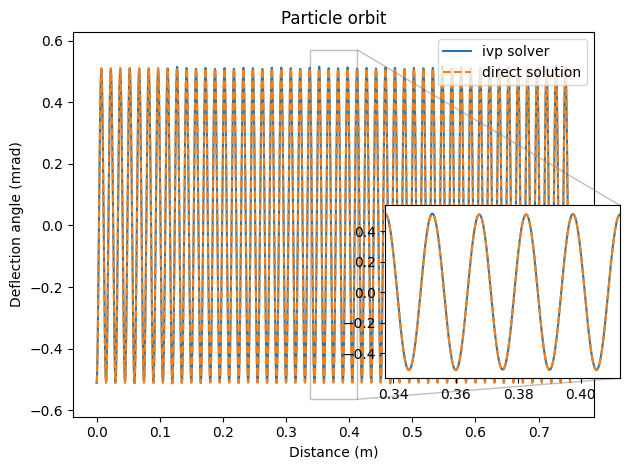

In [7]:
fig, ax = plt.subplots(tight_layout=True)
ax.plot(tracks[0][2], np.arctan2(tracks[0][3], tracks[0][5])*1e3, label='ivp solver')
ax.plot(tracks_d[0][2], np.arctan2(tracks_d[0][3], tracks_d[0][5])*1e3, ls='--', label='direct solution')

xlim = (0.45 * L_u, 0.55 * L_u) 
axin = ax.inset_axes([0.6, 0.1, 0.45, 0.45], xlim=xlim)
axin.plot(tracks[0][2], np.arctan2(tracks[0][3], tracks[0][5])*1e3)
axin.plot(tracks_d[0][2], np.arctan2(tracks_d[0][3], tracks_d[0][5])*1e3, ls='--')
ax.indicate_inset_zoom(axin, edgecolor='grey')

ax.set_title('Particle orbit')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Deflection angle (mrad)')

ax.legend(loc='upper right')

## Setup SychRad and run the calculation

The particle tracks have been already calculated above and can be passed directly to Synchrad.
However, in this example, we will pass only the initial values of the particles together with the `calculate_track` function, to let Synchrad calculate the track right before computing the radiation.
After this, the track is not needed anymore and can be safely deleted.
This approach avoids loading all the tracks in the CPU memory before Synchrad actually starts and allows for dealing with a much higher number of tracks wihtout hiting the memory limitations.

In [8]:
calc_input = {
    "grid": [
        (0.2*omega_u_rad/omega_1m, 1.1 * omega_u_rad/omega_1m),  
        (0, 1/gamma_0),
        (0.0, 2 * np.pi),
        (1024, 64, 64),
    ],  
}
calc = SynchRad(calc_input)

# Define the track list to contain only the initial coordinates of the particles.
tracks0 = Np * [None]
for ip in range(Np):
    tracks0[ip] = [trak0[0][ip], trak0[1][ip], trak0[2][ip], trak0[3][ip], trak0[4][ip], trak0[5][ip], 1, 0.0]

# Pass it to Synchrad together with the calculate track function
calc.calculate_spectrum(particleTracks=tracks0, timeStep=c*dt,
                        comp='cartesian_complex',
                        track_func=track_func)

Creating context with args: {'interactive': True}
Context created successfully on device: NVIDIA A100-PCIE-40GB
Running on 1 devices
  ALL | GPU device: NVIDIA A100-PCIE-40GB
Platform: NVIDIA Corporation
Compiler: OpenCL C 1.2 
Separate it_range for each track will be used


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


## Check if photon number agrees with the theory

In [9]:
EnergyEmitted = calc.get_energy(lambda0_um=lambda_u*1e6, phot_num=True, normalize_to_weights=True)
EnergyEstimate = (7*np.pi*alpha_fs/24) * K0**2 * (1+K0**2/2) * Num_osc

error = (EnergyEmitted - EnergyEstimate) /  EnergyEstimate

print(f'Deviation of emitted photon number from analytic estimate {error*100:.1f} %')

Deviation of emitted photon number from analytic estimate 66.7 %


## Some plots of radiation functions

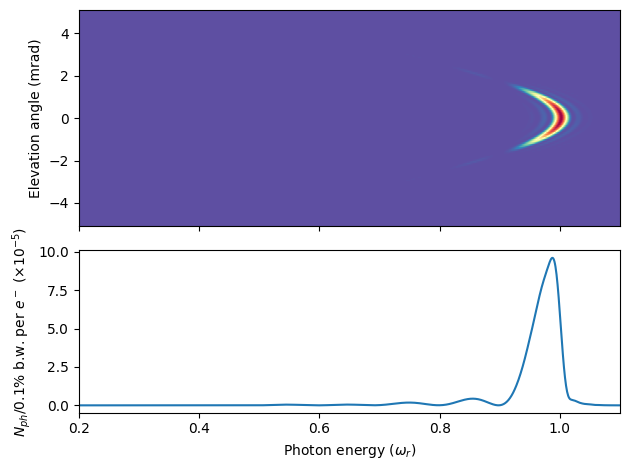

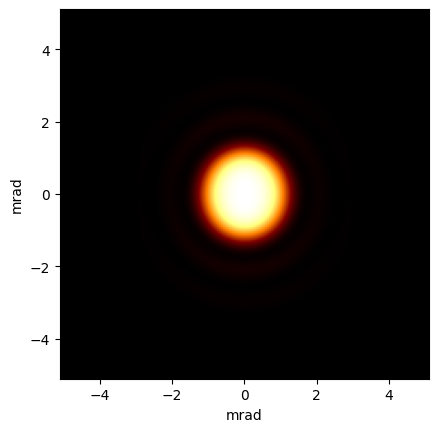

In [10]:
import matplotlib as mpl

spect_ax_normalized = calc.get_spectral_axis() * omega_1m / omega_u_rad

fig, axs = plt.subplots(2, 1, height_ratios=[1, 0.75],
                        sharex=True, tight_layout=True)

spect_val = calc.get_full_spectrum()
spect_val = np.c_[spect_val[:,:,spect_val.shape[2]//2-1][:,::-1], 
                  spect_val[:,1:,0]]

extent = [spect_ax_normalized.min(), 
          spect_ax_normalized.max(), 
          -calc.Args['theta'].max()* 1e3,
          calc.Args['theta'].max()* 1e3 ]

im = axs[0].imshow(spect_val.T,
           extent = extent,
           cmap=plt.cm.Spectral_r,
           # norm=mpl.colors.LogNorm(vmin=0.00001 * spect_val.max()),
           origin='lower', aspect='auto')
axs[0].set_ylabel('Elevation angle (mrad)')

spect_val = calc.get_energy_spectrum(normalize_to_weights=True)
spect_val *= 1e-3
axs[1].plot(spect_ax_normalized, spect_val * 1e5 )
axs[1].set_ylabel(r'$N_{ph}$/0.1% b.w. per $e^-$ ($\times 10^{-5}$)')
axs[1].set_xlabel(r'Photon energy ($\omega_r$)')

spot, extent = calc.get_spot_cartesian(bins=(200, 200))

fig = plt.figure()
plt.imshow(spot.T,
           extent=extent*1e3, cmap=plt.cm.afmhot,
           aspect='equal',
           origin='lower')
[ lab('mrad') for lab in (plt.xlabel, plt.ylabel) ];

## Spot  observed with a band-filter

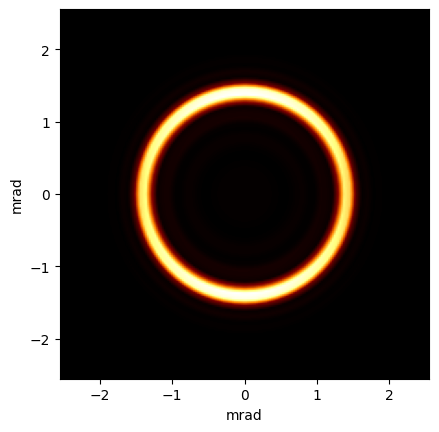

In [11]:
kFilter = 0.93 * omega_u_rad / omega_1m
kBand = 0.003 * kFilter
k = calc.Args['omega'][:,None,None]
spect_filter = np.exp( -(k-kFilter)**2/kBand**2 ) 

spot, extent = calc.get_spot_cartesian(bins=(200,200), th_part=0.5, spect_filter=spect_filter)

plt.figure()
plt.imshow(spot.T,
            extent=extent*1e3, cmap=plt.cm.afmhot,
            origin='lower' )
[ lab('mrad') for lab in (plt.xlabel, plt.ylabel) ];